# 프로젝트 : CIFAR-10 이미지 생성하기 _ver02
## 개요
FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 봅니다.    
초기 시도에서 **성능을 개선하기 위한 노트북**입니다.  
아래 내용들과 함께 초기값, 하이퍼파라미터 등을 변경하여 성능 개선을 시도합니다.  

- 데이터 시각화로 이미지 확인 
    - 실제 이미지와 더 유사하게 표현하기 위해 사용자 정의 'rgb' 스타일 컬러맵을 정의했던 코드 블록을 삭제
    - data type에 맞게 조정하여 clipping 메세지 해결
- 실험1~실험3 : 하이퍼파라미터 조정, 모델 구조 변경 등으로 성능 개선 시도


## 목차
- STEP 1. 작업환경 구성하기
- STEP 2. 데이터셋 구성하기
- STEP 3. 생성자 모델 구현하기
- STEP 4. 판별자 모델 구현하기
- STEP 5. 손실함수와 최적화 함수 구현하기
- STEP 6. 훈련과정 상세 기능 구현하기
- STEP 7. 학습 과정 진행하기
- STEP 8. (optional) GAN 훈련 과정 개선하기 : 실험1~실험3

## 회고

---

In [1]:
# 주요 라이브러리 버전 확인

import tensorflow
import imageio

print(tensorflow.__version__)
print(imageio.__version__)

2.6.0
2.9.0


## STEP 1. 작업환경 구성하기
shell에서 아래의 코드로 generated_samples, training_checkpoints, training_history 폴더 생성

In [ ]:
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

In [2]:
# 패키지 불러오기
import os     # 운영 체제와 상호 작용하기 위한 os 모듈
import glob   # 파일 경로에 대한 패턴 매칭을 위한 glob 모듈
import time   # 시간과 관련된 기능을 사용하기 위한 time 모듈

import PIL          # 이미지 처리를 위한 Python Imaging Library인 PIL(Pillow)
import imageio      # 이미지 입출력을 위한 imageio 모듈
import numpy as np  # 다차원 배열 및 수학적 연산을 위한 NumPy 라이브러리
import tensorflow as tf
from tensorflow.keras import layers    # TensorFlow의 Keras API에서 층을 정의하는 데 사용되는 layers 모듈
from IPython import display            # IPython의 display 모듈에서 display 함수. 주로 이미지나 동적인 콘텐츠를 출력하기 위해 사용
import matplotlib.pyplot as plt        # 데이터 시각화를 위한 Matplotlib 라이브러리에서 pyplot 모듈
%matplotlib inline
# IPython 환경에서 Matplotlib의 그림을 인라인으로 표시하도록 하는 IPython 매직 명령어

print("tensorflow", tf.__version__)

tensorflow 2.6.0


## STEP 2. 데이터셋 구성하기

### 데이터셋 불러오기
CIFAR-10 데이터셋도 tf.keras 안에 있는 datasets에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성할 수 있습니다.  
분류 문제와 달리 라벨 데이터(y_train, y_test)가 필요 없습니다.

In [3]:
# 데이터셋 불러오기

cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 4s 0us/step


(50000, 32, 32, 3)

- dataset 크기 : training images 50,000장 / test images 10,000장
- image size : 32x32
- 10 classes
- [공식문서 참조](https://www.tensorflow.org/datasets/catalog/cifar10)

### 이미지 픽셀 정규화

In [4]:
# 이미지의 픽셀 범위 확인
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


학습에 사용할 train_x의 이미지를 -1 ~ 1로 정규화합니다.

In [5]:
# 픽셀 값 정규화 : -1에서 1사이의 값으로
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [6]:
# 데이터의 shape 확인
train_x.shape

(50000, 32, 32, 3)

### 데이터 시각화로 이미지 확인
로드한 학습 데이터를 시각화를 통해 확인해 봅시다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


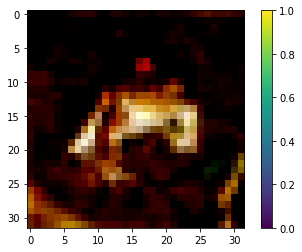

In [7]:
# 첫 번째 데이터를 꺼내서 어떻게 생겼는지 확인
plt.imshow(train_x[0])
plt.colorbar()   # 각 픽셀의 값과 그에 따른 색을 확인
plt.show()

- clipping 메세지를 해결하기 위해 데이터 타입 확인 및 조정

In [12]:
train_x[0].dtype

dtype('float64')

- int : 0~255 사이의 정수로 표현
- float : int를 255로 나눈 값(0~1)으로 표현  

데이터 타입이 float이므로 이미지 시각화할 때만 아래와 같이 변경하여 확인합니다.
- 정규화 했던 데이터를 원복시키고
- float에 맞게 255로 나눠서

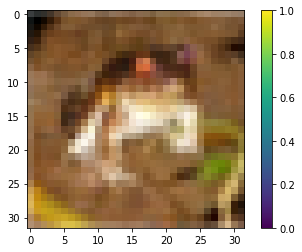

In [15]:
# 첫 번째 데이터를 꺼내서 어떻게 생겼는지 확인
plt.imshow((train_x[0]*127.5 +127.5)/255)
plt.colorbar()   # 각 픽셀의 값과 그에 따른 색을 확인
plt.show()

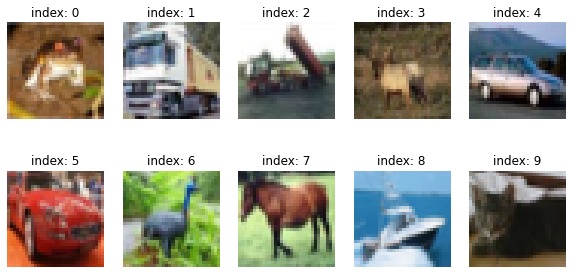

In [19]:
# 10개 데이터 한 번에 확인하기 - for문 활용

plt.figure(figsize=(10, 5))   # 이미지의 전체 프레임의 크기를 결정

for i in range(10):
    plt.subplot(2, 5, i+1)   # 여러 개의 이미지를 한 번에 띄우고 싶을 때에는 plt.subplot(row, col, index)의 형태로 확인
    plt.imshow((train_x[i]+1)/2)
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

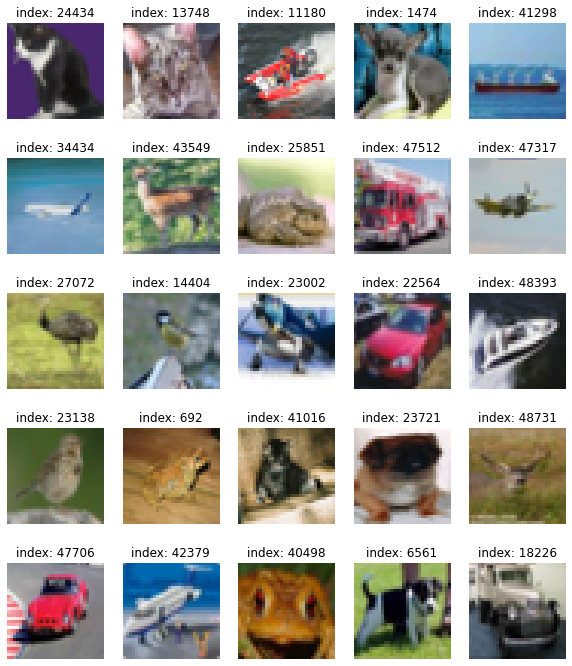

In [21]:
# 이미지 25개를 5x5 배열로 띄워보기. 모든 이미지는 train_images에서 랜덤으로 추출하기.
# (numpy에서 랜덤으로 정수를 추출해 주는 함수를 활용)

plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index]+1)/2)
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

### 미니배치 데이터셋 구성
tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.  
BUFFER_SIZE는 총 데이터 개수인 50000개보다 넉넉하게 60000개로 설정해보겠습니다.

In [22]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [23]:
# 미니 배치 학습 
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# # 참고용 코드 - 한 종류의 데이터만 추출하여 진행하기

# def load_data(label=None):
#     (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
#     if label:
#         df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
#         df = df[df['label']==label]
#         train_x = np.array([i for i in list(df['image'])])
#         df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
#         df = df[df['label']==label]
#         test_x = np.array([i for i in list(df['image'])])
#     return train_x, test_x

## STEP 3. 생성자 모델 구현하기
### 생성자 모델 구현 함수
(32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.

In [24]:
# 생성자 모델(generator model) 구현

def make_generator_model():

	# Start
	model = tf.keras.Sequential()

	# First: Dense layer
	# units은 8x8x256, 편향은 사용하지 않음, 입력 값의 크기는 100차원 벡터
	model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100, )))
	# 배치 정규화 사용
	model.add(layers.BatchNormalization())
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())

	# Second: Reshape layer
	model.add(layers.Reshape((8, 8, 256)))
	assert model.output_shape == (None, 8, 8, 256)   # 주목: 배치사이즈로 None이 주어집니다.

	# Third: Conv2DTranspose layer
	# 커널 크기는 5, stride는 1, 패딩은 사용, 편향은 사용하지 않음
	model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
	# assert는 주어진 조건이 True인지 확인하는 데 사용되는 파이썬의 문장. False인 경우 AssertionError 예외가 발생하며, 프로그램이 중단된다.
	assert model.output_shape == (None, 8, 8, 128)
	# 배치 정규화 사용
	model.add(layers.BatchNormalization())
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())

	# Fourth: Conv2DTranspose layer
	# 커널 크기는 5, stride는 2, 패딩은 사용, 편향은 사용하지 않음
	model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
	assert model.output_shape == (None, 16, 16, 64)
	# 배치 정규화 사용
	model.add(layers.BatchNormalization())
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())

	# Fifth: Conv2DTranspose layer
	model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
										activation='tanh'))
	assert model.output_shape == (None, 32, 32, 3)

	return model

In [25]:
# 생성 모델을 generator라는 변수로 생성하고, 모델 세부 내용인 summary를 출력

generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

### 랜덤 노이즈를 입력으로, 구현한 생성자로 랜덤 이미지 생성하기

In [26]:
# 랜덤 노이즈 벡터 만들기
noise = tf.random.normal([1, 100])

In [27]:
# 랜덤 노이즈 벡터로 결과물 만들어보기
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞습니다.  
첫 번째 1은 1개(batch_size=1)라는 뜻을, 그 뒤로는 (32, 32, 3) 사이즈 이미지가 생성되었다는 뜻을 가집니다.

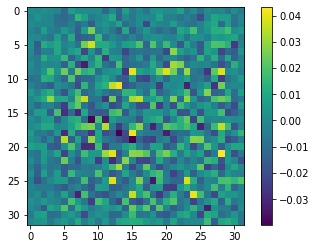

In [28]:
# 이미지 시각화

plt.imshow(generated_image[0, :, :, 0])   # 2차원 이미지만 보여줄 수 있으므로 0, 3번째 축의 인덱스 0으로 설정하여 이미지 꺼내기
plt.colorbar()
plt.show()

아직은 모델이 전혀 학습하지 않은 상태이기 때문에 아무런 의미가 없는 노이즈 같은 이미지가 생성되었습니다.  
모델이 점차 학습해 나가며 제대로 된 이미지를 생성하기를 바라봅니다.

## STEP 4. 판별자 모델 구현하기
### 판별자 모델 구현 함수
(32, 32, 3)의 이미지를 입력으로 받아 1dim 판별결과(단 하나의 숫자, 진짜라고 판단하는 정도)를 출력하는 판별자 모델 구현 함수를 작성해 봅니다.

In [29]:
# 판별자 모델 구현 (discriminator model)

def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    # 필터의 크기는 5이며 64개 사용, stride는 2, 패딩은 사용, 입력 값의 크기는 준비된 흑백 사진
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    # 필터의 크기는 5이며 128개 사용, stride는 2, 패딩은 사용
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [30]:
# 판별 모델을 discriminator라는 변수 이름으로 생성하고, 모델 세부 내용인 summary를 출력

discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

### 판별자 모델이 판별한 결과값 확인
위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [31]:
# 아까 생성했던 가짜 이미지를 판별자에 입력하고 결과 확인해보기

decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00105819]], dtype=float32)>

텐서플로우의 텐서 형태로 출력이 되었습니다. 이 값 또한 아직은 아무런 의미가 없는 값일 것입니다.  
이제 모델 학습을 합니다.

## STEP 5. 손실함수와 최적화 함수 구현하기

In [32]:
# 판별값을 0~1 사이의 값으로 정규화할 수 있도록 설정

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### generator_loss 구현
generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 됩니다.  
즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가집니다.

In [33]:
# generator loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator_loss 구현
반면, discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산합니다.  
real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하면 됩니다!  

최종 discriminator_loss 값은 이 둘을 더한 값입니다.

In [34]:
# discriminator loss

def discriminator_loss(real_output, fake_output):
    # 손실함수는 cross entropy를 사용, ones_like를 활용
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # 손실함수는 cross entropy를 사용, zeros_like를 활용
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss
    return total_loss

### discriminator accuracy 구현
판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅니다.  
특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용합니다.  

real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적입니다.  
fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻이기 때문입니다.

In [35]:
# discriminator accuracy
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

- greater_equal : 크거나 같다
- less : 작다

### 최적화 함수(optimizer)
Adam 최적화 기법을 활용해 최적화 함수(생성자와 판별자를 최적화하는 optimizer)를 설정해보겠습니다.  
Adam 함수 또한 tf.keras.optimizers 안에 있습니다.
중요한 하이퍼 파라미터인 "learning rate"는 0.0001로 설정해보겠습니다.

In [37]:
# 생성자와 구분자의 optimizer 만들기

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### 생성자가 생성한 샘플 확인
또한, 매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인할 것입니다.  

샘플은 한 번에 16장을 생성하도록 하겠습니다.   
생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 합니다.  
즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어 두도록 하겠습니다.

In [38]:
# 생성자가 생성한 샘플 확인하기

noise_dim = 100
num_examples_to_generate = 16    # 한 번에 몇 장의 샘플을 생성할 것인지 설정

# 고정된 seed 노이즈 만들기 : 매번 같은 노이즈로 생성하여 진전 과정을 확인할 수 있으므로
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## STEP 6. 훈련과정 상세 기능 구현하기
### train_step() 함수 구현
1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅니다.    
@tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동 변환됩니다.

In [41]:
# train_step 함수 구현

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
        #(8) gradient 계산
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값


# generator.trainable_variables : generator의 학습이 가능한 모듈들, 변수 등

[tf.function](https://www.tensorflow.org/guide/function?hl=ko)

아래는 train_step 함수의 주석입니다.  

- (1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
- (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
- (3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
- (4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
- (5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
- (6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
- (7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산
- (8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
- (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신 (계산된 그래디언트를 이용하여 생성자와 판별자의 모델 파라미터를 업데이트)
- (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

### generate_and_save_images() 함수 구현
16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅니다.  

In [48]:
# 샘플 생성 함수 구현 (train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는)

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, 0]+1)/2)
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()


- 04d : 4번째 자리까지 0을 채움. int
- 04f : 4번째 자리까지 0을 채움. float

### 시각화 함수 draw_train_history() 구현
훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅니다.

In [50]:
# gen, disc의 loss, accuracy 시각화 함수 (train_step()함수가 리턴하는)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

### 모델 checkpoint 만들기 - 모델을 정기적으로 저장
training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅니다.

In [51]:
# model checkpoint 만들기

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 7. 학습 과정 진행하기

In [52]:
# 모델 학습 함수

def train(dataset, epochs, save_every):
    start = time.time()  # 학습 시작 시점 기록
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()   # 각 에폭의 시작 시간을 기록
        # 주어진 데이터셋을 이용하여 미니배치 단위로 GAN을 훈련
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            # 매 50번째 이터레이션마다 결과를 출력하고 생성된 이미지를 시각화하여 모니터링합니다.
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)   # 각 에폭이 끝날 때마다 생성자에 의해 생성된 이미지를 시각화하여 저장
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        # 지정된 주기(save_every)마다 모델의 체크포인트를 저장
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)   # 전체 훈련이 완료된 후에 마지막으로 생성된 이미지를 시각화하여 저장
        print('Time for training : {} sec'.format(int(time.time()-start)))   # 전체 훈련 소요 시간을 출력

        draw_train_history(history, epoch)

#### 이터레이션이란?

- GAN(Generative Adversarial Network)이나 다른 머신러닝 모델의 훈련에서, 전체 훈련 데이터셋을 한 번 훑는 것을 "에폭(epoch)"이라고 합니다. 그리고 한 번의 에폭 동안에 전체 데이터셋을 여러 번 반복하여 사용하며, 각 반복을 이터레이션이라고 합니다.
- 이터레이션의 개념은 주로 미니배치 학습(mini-batch learning)에서 사용됩니다. 미니배치 학습에서는 전체 데이터셋을 작은 미니배치로 나누어 각각의 미니배치에 대해 모델을 업데이트합니다. 이때 한 번의 미니배치에 대한 업데이트를 하나의 이터레이션이라고 부릅니다.
- 예를 들어, 1000개의 훈련 샘플이 있는 데이터셋을 사용하여 배치 크기가 50인 미니배치 학습을 한다면, 각 에폭에서 20번의 이터레이션을 거치게 됩니다. 총 이터레이션 수는 에폭 수와 미니배치 수의 곱으로 계산됩니다.

#### save_every란?
- save_every는 모델의 학습 도중 일정 주기마다 모델의 체크포인트를 저장하기 위한 매개변수입니다.
- save_every는 몇 번의 에폭(epoch)이 지날 때마다 체크포인트를 저장할 것인지를 나타냅니다.
- 예를 들어, save_every=5로 설정되어 있다면, 매 5번의 에폭이 끝날 때마다 모델의 체크포인트가 저장됩니다. 

In [46]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 모델 학습

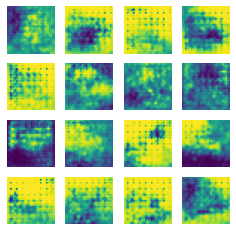

Time for training : 798 sec


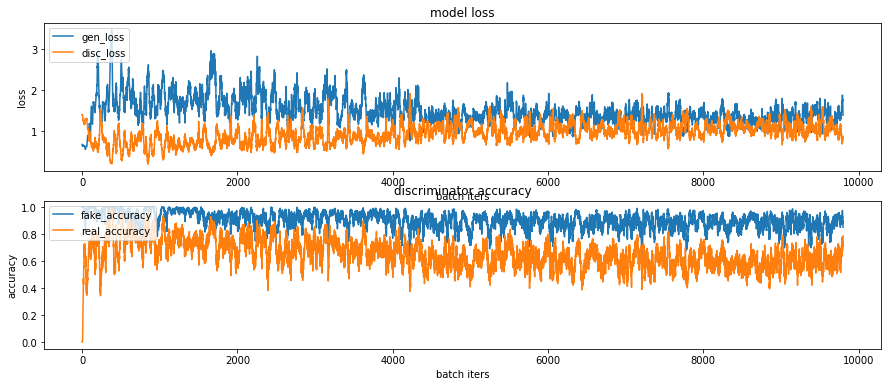

CPU times: user 13min 31s, sys: 1min 22s, total: 14min 54s
Wall time: 13min 20s


In [47]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있어
# 진행 과정을 수시로 확인할 수 있습니다.

> 그래프 분석  
> - real과 fake image를 판별할 줄 모를 정도로 잘 생성되었을 때 gen_loss와 disc_loss 는 유사한 수준(수치, 흐름)을 보인다.
> - gen_loss, disc_loss의 수치는 더 떨어져야 하는 상태
> - fake_accuracy, real_accuracy는 처음엔 1에 가깝다가 0.5로 낮아져야 합니다.  

> ⭐️ loss는 학습이 잘 되었는지를 확인, accuracy는 모델의 성능을 확인하는 것 기억하기!!!

> 일단은 현재까지의 학습과정을 gif로 시각화해보고, 더 많은 epoch으로 학습해보겠습니다.

### 학습과정 시각화하기
학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해봅니다.

In [49]:
# 샘플 이미지들로 gif 파일 만들기

anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan.gif

-rw-r--r-- 1 root root 3643713 Jan 28 06:16 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan.gif


### 학습 epoch을 추가 진행하거나, 학습한 모델을 활용하여 이미지 생성 시 - checkpoint 모듈의 활용
(참고) 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다.   
그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것입니다.  
우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다.   
이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.  
아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시입니다.

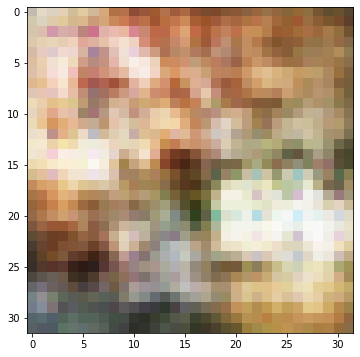

In [53]:
# 체크포인트 파일이 저장된 디렉토리 경로를 설정 
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

# 가장 최근의 체크포인트 파일 경로를 가져오기
latest = tf.train.latest_checkpoint(checkpoint_dir)
# 가져온 최근의 체크포인트로부터 모델의 가중치를 복원
checkpoint.restore(latest)

# 복원된 모델에서 생성자(generator)와 판별자(discriminator) 가져오기
generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])    # 100차원의 랜덤한 노이즈를 생성
generated_image = generator(noise, training=False)    # 생성자에 랜덤한 노이즈를 입력으로 주어 가짜 이미지를 생성

np_generated = generated_image.numpy()    # TensorFlow Tensor를 NumPy 배열로 변환
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization (생성된 이미지를 다시 정규화 이전의 값으로 변환)
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

다시 정리하면 이 코드는 미리 학습한 DCGAN 모델을 로드하고, 해당 모델로부터 랜덤한 노이즈를 입력으로 받아 CIFAR-10 이미지와 유사한 이미지를 생성하여 확인하는 과정입니다.  

- 이어서 EPOCHS=50으로 학습을 재개해보겠습니다.

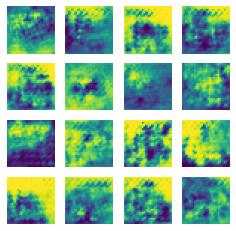

Time for training : 796 sec


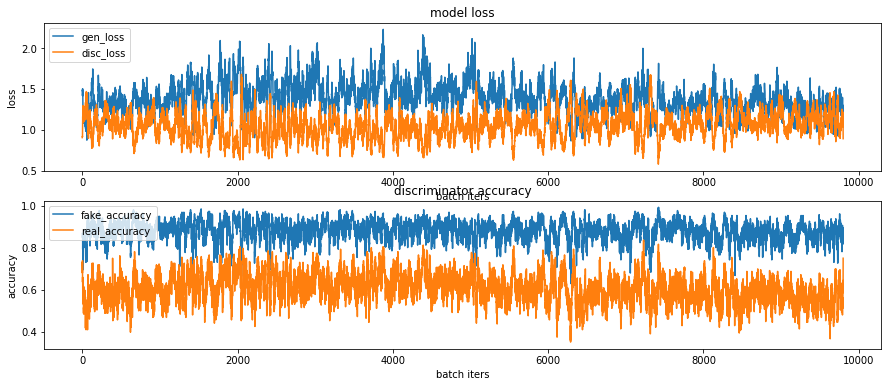

CPU times: user 13min 34s, sys: 1min 22s, total: 14min 56s
Wall time: 13min 17s


In [54]:
%%time
train(train_dataset, EPOCHS, save_every)

>- loss는 소폭 하락하였습니다.
>- real_accuracy는 0.5에 가깝게 하락하는 듯하나, fake_accuracy는 변화가 없습니다.

## STEP 8. (optional) GAN 훈련 과정 개선하기
STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅니다.
모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.
아래 페이지들에서 개선을 위한 아이디어를 얻어보았습니다.

- [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
- [10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)
- [Tips for Training Stable Generative Adversarial Networks](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)
- [Improved Techniques for Training GANs(paper)](https://proceedings.neurips.cc/paper_files/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf)

## 실험1 : BATCH_SIZE=1024 으로 조정
fake_accuracy를 0.5 수준까지 떨어트려야 합니다. 다시 말하면 일반화 성능이 향상되어야 한다는 의미!!     

-> batch_size를 키워서 일반화 성능 개선을 시도합니다.

In [55]:
BUFFER_SIZE = 60000
BATCH_SIZE = 1024

# 미니 배치 학습 
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [56]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

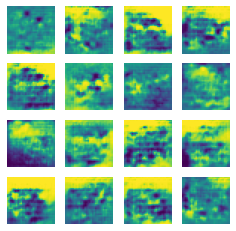

Time for training : 652 sec


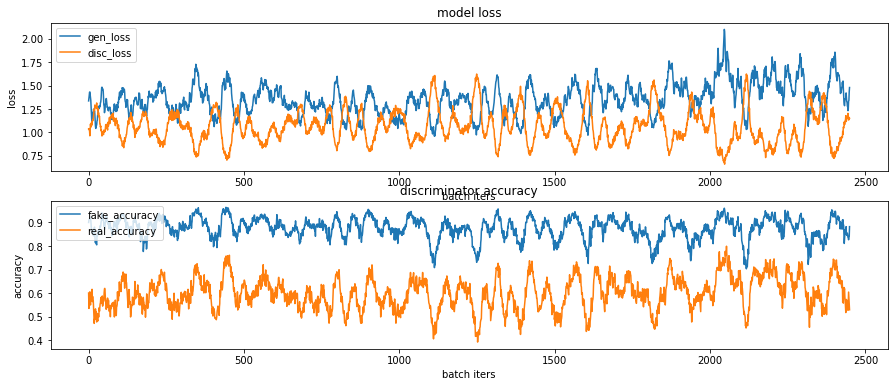

CPU times: user 10min 48s, sys: 59.7 s, total: 11min 48s
Wall time: 10min 53s


In [57]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있어
# 진행 과정을 수시로 확인할 수 있습니다.

In [58]:
# 샘플 이미지들로 gif 파일 만들기

anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan05.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan05.gif

-rw-r--r-- 1 root root 3596226 Jan 28 07:07 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan05.gif


> 추가적인 에폭에 따른 변화가 없는 것으로 보아 오버피팅이 예상됩니다.   

## 실험2 : discriminator의 learning rate를 낮춰보자.
현재 판별자의 성능이 우세합니다. 따라서 생성자가 real image처럼 더 잘 만들 수 있도록 판별자의 학습률을 떨어트려봅니다.  
(또는 gen_loss와 disc_loss 사이의 weight를 조정하는 방법도 있습니다.   
예를 들면 gradient 계산 시 gen_loss를 2*gen_loss로 변경, 즉 gen_loss의 가중치를 2배로 설정하는 등)   

모델을 처음부터 학습시켜봅니다.

In [59]:
# 생성자와 구분자의 optimizer 만들기 - disc 학습률 1e-4에서 1e-5로 변경

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

In [60]:
# train_step 함수 구현

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
        #(8) gradient 계산
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값


# generator.trainable_variables : generator의 학습이 가능한 모듈들, 변수 등

In [61]:
# model checkpoint 만들기

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

- 이어서 EPOCHS = 100으로 추가 학습합니다.

In [62]:
save_every = 5
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

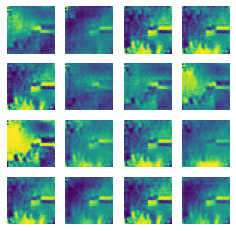

Time for training : 1337 sec


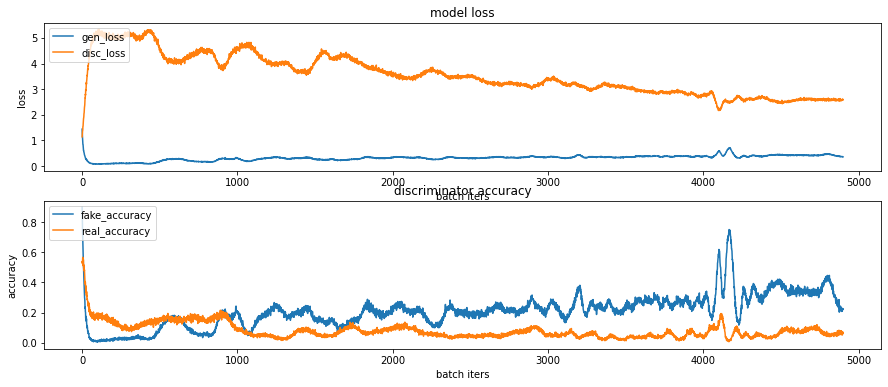

CPU times: user 21min 39s, sys: 1min 57s, total: 23min 36s
Wall time: 22min 18s


In [63]:
%%time
train(train_dataset, EPOCHS, save_every)

>- loss가 monotonic해졌습니다. 
>    - 즉 모델이 안정적으로 학습하고 있음을 알 수 있습니다.  
>    - 수치 자체는 더 떨어져야 하므로 더 많은 학습이 필요합니다. 
    
>- fake_accuracy는 소폭 상승하고 있는 것으로 보아 판별자의 학습률을 작게 조정한 것의 효과가 보입니다.
>    - 그러나 학습률 수치가 낮으므로 더 많은 학습이 필요합니다.
>    - 또한 accuracy의 증가 속도가 더디므로 학습률을 크게 조정해보는 것이 좋을 것이라 판단됩니다.

In [65]:
# 샘플 이미지들로 gif 파일 만들기

anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan06.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan06.gif

-rw-r--r-- 1 root root 3604528 Jan 28 07:50 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan06.gif


>gif 이미지 결과 
>- 어느정도 윤곽이 보이지만 어떤 것인지 알 수 없는 상태로, 학습 중에 local minimum에 빠진 것으로 예상됩니다.
>- 학습률을 높여서 local minimum에서 빠져나오도록 해보겠습니다.
>![dcgan06]('/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan06.gif)

## 실험3 : 생성자 모델 layer를 깊게 쌓기
생성자 모델의 성능 향상을 위해 새로운 모델을 만들어 layer를 더 깊게 쌓고, 학습도 새로 진행해보겠습니다.  
- layer 깊게 쌓기 : 분석을 위해 conv2D층을 conv2DTranspose층 다음에 쌓겠습니다.
- discriminator 학습률 : 0.00005로 조정 (실험2에 비해 크게, 초기 모델에 비해 작게)
- 모델이 무거워져서 메모리 오버플로우를 고려해 배치사이즈를 조정합니다. BATCH_SIZE = 512
- Epochs = 100

In [75]:
# 생성자 모델(generator model) 구현

def make_generator_model():

	# Start
	model = tf.keras.Sequential()

	# First: Dense layer
	# units은 8x8x256, 편향은 사용하지 않음, 입력 값의 크기는 100차원 벡터
	model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100, )))
	# 배치 정규화 사용
	model.add(layers.BatchNormalization())
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())

	# Second: Reshape layer
	model.add(layers.Reshape((8, 8, 256)))
	assert model.output_shape == (None, 8, 8, 256)   # 주목: 배치사이즈로 None이 주어집니다.
    
	# Third: Conv2DTranspose layer
	# 커널 크기는 5, stride는 1, 패딩은 사용, 편향은 사용하지 않음
	model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
	# assert는 주어진 조건이 True인지 확인하는 데 사용되는 파이썬의 문장. False인 경우 AssertionError 예외가 발생하며, 프로그램이 중단된다.
	assert model.output_shape == (None, 8, 8, 128)
	# 배치 정규화 사용
	model.add(layers.BatchNormalization())
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())
    
    # Fourth: Conv2D layer
	model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    # 배치 정규화 사용
	model.add(layers.BatchNormalization())
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())

	# Fifth: Conv2DTranspose layer
	# 커널 크기는 5, stride는 2, 패딩은 사용, 편향은 사용하지 않음
	model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
	assert model.output_shape == (None, 16, 16, 64)
	# 배치 정규화 사용
	model.add(layers.BatchNormalization())
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())
    
    # Sixth: Conv2D layer
	model.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    # 배치 정규화 사용
	model.add(layers.BatchNormalization())
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())

	# Seventh: Conv2DTranspose layer
	model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
										activation='tanh'))
	assert model.output_shape == (None, 32, 32, 3)

	return model

In [76]:
# 생성 모델을 generator라는 변수로 생성하고, 모델 세부 내용인 summary를 출력

generator = make_generator_model()

generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_7 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 128)        

In [77]:
# 판별자 모델 구현 (discriminator model)

def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    # 필터의 크기는 5이며 64개 사용, stride는 2, 패딩은 사용, 입력 값의 크기는 준비된 흑백 사진
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    # 필터의 크기는 5이며 128개 사용, stride는 2, 패딩은 사용
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [78]:
# 생성 모델을 discriminator 변수로 생성하고, 모델 세부 내용인 summary를 출력

discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

In [79]:
# 생성자와 구분자의 optimizer 만들기

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-5)  # 0.00005

In [83]:
# train_step 함수 구현

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
        #(8) gradient 계산
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값


# generator.trainable_variables : generator의 학습이 가능한 모듈들, 변수 등

In [84]:
BUFFER_SIZE = 60000
BATCH_SIZE = 512

# 미니 배치 학습 
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [85]:
save_every = 10
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

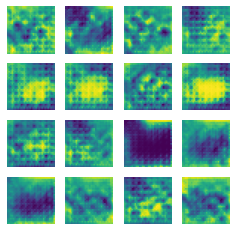

Time for training : 1501 sec


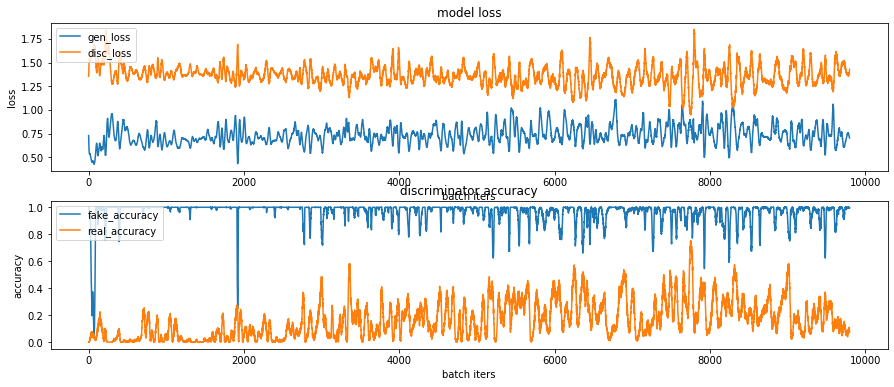

CPU times: user 24min 54s, sys: 2min 10s, total: 27min 4s
Wall time: 25min 2s


In [86]:
%%time
train(train_dataset, EPOCHS, save_every)

In [87]:
# 샘플 이미지들로 gif 파일 만들기

anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan07.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan07.gif

-rw-r--r-- 1 root root 3661622 Jan 28 08:50 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan07.gif


> - gen_loss는 0.5 수준으로 가까워졌으나, disc_loss는 여전히 학습이 잘 이루어지지 않고 있는 듯합니다.
> - 이후 실험에서 다시 시도한다면 실험3의 다른 조건은 동일하되, 학습률만 초기 실험과 동일하게 조정하여 그래프 추이를 보는 것이 어떨까 싶습니다.

### GAN 모델구조, 학습과정 실험표

|실험|내용|부가 설명|
|:------|:---|:---|
|초기 모델|배치사이즈 256|초기값 에폭 50으로 학습 후 추가로 에폭 50으로 학습|
|실험 1|배치사이즈 64로 변경|초기값 에폭으로 100 설정|초기 모델과 같은 모델|
|실험 2|disc 학습률 1e-4에서 1e-5로 변경|생성자의 학습이 더 잘 이루어지도록 하기 위해 / 초기 모델과 같은 모델|
|실험 3|conv2D 2개 추가, 학습률 0.00005로 조정, BATCH_SIZE = 512, Epochs = 100|새로운 모델 구현 및 학습|


---
## 회고
### KEEP
- GAN 모델링의 개념과 목표를 이해하며 진행했다.
- 근거를 가지고 하이퍼파라미터 조정 및 실험하였다.

### PROBLEM
- 성능 개선이 쉽지 않다. 
- 아직 코드를 백지에서 작성하라고 하면 못할 것 같다.

### TRY
- 성능 개선에서 이슈가 되는 사안들을 어떻게 개선할 수 있을지 더 많은 방법 탐색과 시도 해보기.
- 이번에 학습한 코드를 일단 외워서 혼자 작성해보기

### 루브릭
1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.	
오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.
2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.	
gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.
3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.	
모델구조 변경 혹은 학습과정 개선 아이디어를 추가적으로 적용해보았고, 적용 전과 비교하였을 때의 내용을 표와 같은 시각적 자료로 작성하였다.